In [4]:
# Se importan las librerias que se van a utilizar
import pandas as pd
import numpy as np
import talib
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
# Se elige el PAR
PAIR = 'USDJPY' 

# Lee el archivo CSV
df = pd.read_csv(f"data/{PAIR}/{PAIR}_Candlestick_5_m_BID_01.01.2023-31.07.2023.csv", sep="," )

# Se renombra las columnas del DataFrame
df.columns = ["DateTime", "Open", "High", "Low", "Close", "Volume"]

# Se eliminan los valores NaN
df = df.dropna(subset=['Close'], how='any')

# Se seleccionan los datos con volumen
df_filtered = df[df['Volume'] != 0]

# Se carga en HISTORICAL_DATA_AUX 
historical_data_aux = df_filtered.reset_index(drop=True).copy()

# Los primeros 320 datos se usan para calculos posteriores, como el VAR, o las operaciones de entramiento, por eso se tienen que quitar esos primeros datos
historical_data = historical_data_aux[320:]
historical_data.reset_index(drop=True, inplace=True)
historical_data.head()

,DateTime,Open,High,Low,Close,Volume
0,03.01.2023 00:50:00.000,130.723,130.741,130.639,130.639,949.91
1,03.01.2023 00:55:00.000,130.639,130.642,130.570,130.606,984.92
2,03.01.2023 01:00:00.000,130.612,130.677,130.612,130.659,1078.22
3,03.01.2023 01:05:00.000,130.659,130.714,130.578,130.628,1477.32
4,03.01.2023 01:10:00.000,130.626,130.630,130.198,130.209,2890.75


In [7]:
# Datos para calcular los primeros valores para VaR
data_var_aux = historical_data_aux.head(320) # Para el modelo de ML para coger los primeros 20 datos 
# Porque luego se hacen lags y se queda en NaN
data_var = data_var_aux[19:]
data_var.reset_index(drop=True, inplace=True)

#### Se escoge un RandomForest, y se procede a buscar los mejores parámetros

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Mejores hiperparámetros: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0005
Root Mean Squared Error (RMSE): 0.0009
------------------------


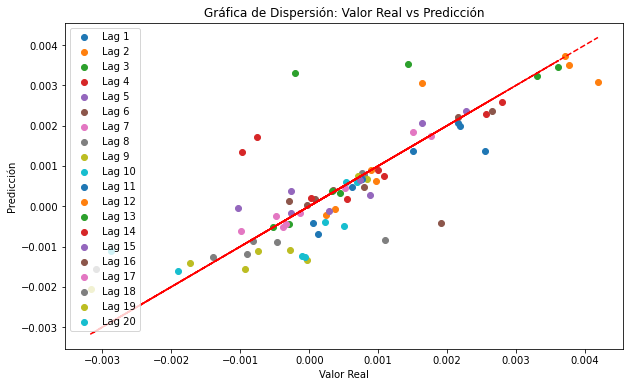

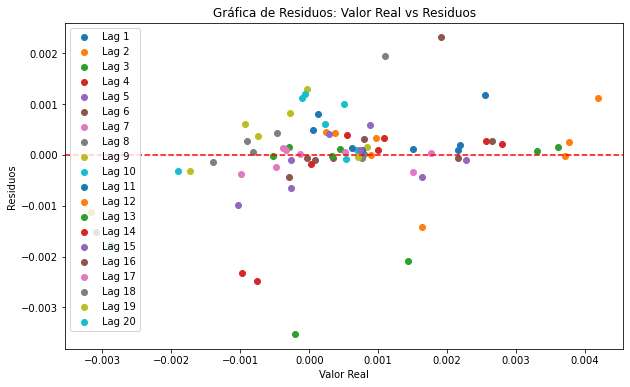

Tiempo de ejecución: 110.0339846611023 segundos


In [9]:
start_time = time.time()

df = data_var_aux[['Close']].copy()

# Crear los lags
window_size = 20
for i in range(1, window_size + 1):
    df[f'lag_{i}'] = np.log(df['Close'] / df['Close'].shift(i))

# Eliminar los primeros 20 datos que contienen NaNs debido a la creación de lags
df = df.dropna().reset_index(drop=True)

# Eliminar columna Close
df = df.drop(columns='Close')

# Reshape y reset index
df = df.T
df.reset_index(drop=True, inplace=True)


# Crear X e y
X = df.iloc[:, :-20]  # Seleccionar todas las filas y las columnas excepto las últimas 20
y = df.iloc[:, -20:]  # Seleccionar todas las filas, y las columnas desde las últimas 20 

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Definir una cuadrícula de hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Crear una instancia de GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo con los hiperparámetros encontrados
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular las métricas de evaluación para el conjunto completo de predicciones
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Imprimir los mejores hiperparámetros y las métricas de evaluación
print(f"Mejores hiperparámetros: {best_params}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print("------------------------")

# GRAFICA QUE ME MUESTRA TODOS LOS DATOS JUNTOS 

# Gráfica de dispersión
plt.figure(figsize=(10, 6))
for i in range(20):
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], label=f'Lag {i+1}')
    plt.plot(y_test.iloc[:, i], y_test.iloc[:, i], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Gráfica de Dispersión: Valor Real vs Predicción')
plt.legend()
plt.show()

# Gráfica de residuos
plt.figure(figsize=(10, 6))
for i in range(20):
    residuals = y_test.iloc[:, i] - y_pred[:, i]
    plt.scatter(y_test.iloc[:, i], residuals, label=f'Lag {i+1}')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valor Real')
plt.ylabel('Residuos')
plt.title('Gráfica de Residuos: Valor Real vs Residuos')
plt.legend()
plt.show()

end_time = time.time()
execution_time = end_time - start_time

print("Tiempo de ejecución:", execution_time, "segundos")

#### Una vez se tiene el modelo entrenado, se procede a aplicar dicho modelo a la estrategia de trading

In [29]:
start_time = time.time()

### Se inicializan las variables
close_data = historical_data['Close']
rsi_data = talib.RSI(close_data, timeperiod=14) # devuelve una serie de pandas
sell_threshold = 70 # Limites para el RSI
buy_threshold = 30 # Limites para el RSI
position = 0 # Posicion incial
entry_price = 0 # Precio inicial a 0
signals = []
initial_balance = 100000
balance = initial_balance # Balance inicial que se irá actualizando
pip = 0.01
stop_loss = 10*pip # Se define un SL fijo
take_profit = 20*pip # Igual con el TP es fijo
risk = 1 # Se define el riesgo como el 1% de balance
transactions = pd.DataFrame(columns=['Date','Action','Price']) # Se guardaran todas las transacciones
position_history = pd.DataFrame(columns=['Date','Position']) # Aqui se guardara todo el resgitro de los distintos movimientos
balance_history = pd.DataFrame(columns=['DateTime','Balance_history','Action']) # Aqui se llevará el registro del balance

# Inicia el balance
balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[0]],'Balance_history':[balance],'Action': ['Start']})], ignore_index=True)

#   0 - Fuera del mercado
#   1 - Compra
#  -1 - Venta
#   2 - SL Compra
#  -2 - SL Venta
#   3 - TP Compra
#  -3 - TP Venta
#  10 - Hold de compra 
# -10 - Hold de Venta

# Aqui iran los datos para realizar el calculo del VaR
change = data_var['Close']
change.reset_index(drop=True)

### Estrategia de Trading ###
for i in range(len(close_data)):
    
    # Se actualiza la serie change con el valor de close_data[i]
    # Se elimina el dato más viejo en CHANGE (primer dato)
    change = change.iloc[1:].reset_index(drop=True)
    # Se agrega el nuevo dato (close_data.iloc[i]) al final de CHANGE
    change = change.append(pd.Series(close_data.iloc[i])).reset_index(drop=True)
    
    ### Aqui se van a predecir los 20 siguientes rendimientos continuos ###
    # A mi serie que seria CHANGE le quito los 20 primeros que son las más viejos y asi le añadiré las 20 predicciones
    change_aux = change.iloc[20:].reset_index(drop=True)
    
    # Se calcula el rendimiento continuo
    data_RCont = np.log(change_aux/change_aux.shift(1))
    data_RCont = data_RCont.dropna()

    # Hago un reshape para pasar a tenerlo en formato (1,280)
    data_RCont_array = np.array(data_RCont).reshape(1, -1)
    
    # Se aplica el regresor y se predice los siguientes 20 valores
    pred = best_model.predict(data_RCont_array)
    
    # Se concatenan los dos array
    pred_concat = np.concatenate((data_RCont_array, pred), axis=1)
    
    # Se utiliza un flatten() para obtener un array unidimensional
    pred_concat = pred_concat.flatten()

    # Se convierte el array unidimensional en una serie de pandas
    rend_cont_pred = pd.Series(pred_concat)  
    
    # Una vez se tiene añadida la predicción se procede al calculo del Value at Risk
    # Se calcula el VaR_Buy
    alpha_buy = 0.05
    t = 1
    VaR_buy = (np.quantile(rend_cont_pred, alpha_buy))*np.sqrt(t)
    # Se calcula el VaR_sell
    alpha_sell = 0.95
    VaR_sell = (np.quantile(rend_cont_pred, alpha_sell))*np.sqrt(t)
    
    # Si se está fuera de mercado (0), o en TP (3,-3) o en SL (2,-2) entonces:
    if position in [0, 2, 3, -2, -3, 22, 33, -22, -33]:
        # Si se cumple la condición se entra en COMPRA
        if rsi_data.iloc[i] <= buy_threshold:
            # SE ENTRA EN COMPRA
            # Se define la posición en Compra, y se marca en position, en signals, y se marca el precio de entrada
            position = 1
            signals.append(1)
            entry_price = close_data.iloc[i]
            
            # Se coloca SL y TP           
            stop_loss_price = round((float(entry_price) - stop_loss),3)
            take_profit_price = round((float(entry_price) + take_profit),3)
            
            # Se guarda el registro
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Buy'], 'Price': [entry_price]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [1]})], ignore_index=True)

        # Si se cumple la condición se entra en VENTA
        elif rsi_data.iloc[i] >= sell_threshold:
            # SE ENTRA EN VENTA
            # Se define la posición en Venta, y se marca en position, en signals, y el precio de entrada
            position = -1 
            signals.append(-1)
            entry_price = close_data.iloc[i]
            
            # Se coloca SL y TP
            stop_loss_price = round((float(entry_price) + stop_loss),3)
            take_profit_price = round((float(entry_price) - take_profit),3)
            
            # Se guarda el registro
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Sell'], 'Price': [entry_price]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-1]})], ignore_index=True)

        # Si no se cumple ni compra ni venta entonces se mantiene fuera de mercado (0)
        else:
            position = 0
            signals.append(0) 
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Outside_market'], 'Price': [0]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [0]})], ignore_index=True)

    # Si se está en COMPRA, se cierra la posición con take_profit, o bien se cierra por VaR, o stop_loss, si no se mantiene
    elif position in [1, 10]:
        # Take Profit de Compra
        if float(close_data.iloc[i]) >= take_profit_price:
            # Se actualiza el balance, position, transactions y position_history
            balance = (initial_balance*(risk*2/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Take_Profit_Long']})], ignore_index=True)
            position = 3
            signals.append(3)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_Long'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [3]})], ignore_index=True)

        # Aqui entra Value at Risk
        elif data_RCont.iloc[-1] <= VaR_buy:
            if float(entry_price) <= float(close_data.iloc[i]):
                # Beneficio
                last_pips = (float(close_data.iloc[i]) - float(entry_price)) / pip
                last_risk = (last_pips*risk) / (stop_loss/pip)
                balance = (initial_balance*(last_risk/100)) + balance
                balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Positive_Close_VaR_buy']})], ignore_index=True)                
                position = 33
                signals.append(33)
                transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_VaR_Buy'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
                position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [33]})], ignore_index=True)
            else:
                # Perdida
                last_pips = (float(entry_price) - float(close_data.iloc[i])) / pip
                last_risk = (last_pips*risk) / (stop_loss/pip)
                balance = (initial_balance*(last_risk/100)) + balance
                balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Negative_Close_VaR_buy']})], ignore_index=True)
                position = 22
                signals.append(22)
                transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_VaR_Buy'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
                position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [22]})], ignore_index=True)
        
        # Stop Loss de Compra
        elif float(close_data.iloc[i]) <= stop_loss_price:
            # Se actualiza el balance, position, transactions y position_history
            balance = (initial_balance*(risk*(-1)/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Stop_Loss_Long']})], ignore_index=True)
            position = 2
            signals.append(2)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_Long'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [2]})], ignore_index=True)
        
        # Se mantiene la compra
        else:
            position = 10
            signals.append(10)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Hold_Buy'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [10]})], ignore_index=True)
            
    # Si se está en VENTA, se cierra la posición con take_profit, o bien se cierra por VaR, o stop_loss, si no se mantiene
    elif position in [-1, -10]:
        # Take Profit de Venta
        if float(close_data.iloc[i]) <= take_profit_price:
            # Se actualiza el balance, position a -3, transactions y position_history
            balance = (initial_balance*(risk*2/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Take_Profit_Short']})], ignore_index=True)
            position = -3
            signals.append(-3)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_Short'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-3]})], ignore_index=True)
        
        # Aqui entra Value at Risk
        elif data_RCont.iloc[-1] >= VaR_sell: 
            if float(entry_price) >= float(close_data.iloc[i]):
                # Beneficio
                last_pips = (float(close_data.iloc[i]) - float(entry_price)) / pip
                last_risk = (last_pips*risk) / (stop_loss/pip)
                balance = (initial_balance*(last_risk/100)) + balance
                balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Positive_Close_VaR_sell']})], ignore_index=True)
                position = -33
                signals.append(-33)
                transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_VaR_Sell'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
                position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-33]})], ignore_index=True)
            else:
                # Perdida
                last_pips = (float(entry_price) - float(close_data.iloc[i])) / pip
                last_risk = (last_pips*risk) / (stop_loss/pip)
                balance = (initial_balance*(last_risk/100)) + balance
                balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Negative_Close_VaR_sell']})], ignore_index=True)
                position = -22
                signals.append(-22)
                transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_VaR_Sell'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
                position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-22]})], ignore_index=True)
        
        # Stop Loss de Venta
        elif float(close_data.iloc[i]) >= stop_loss_price:
            # Se actualiza el balance, position a -2, transactions y position_history
            balance = (initial_balance*(risk*(-1)/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Stop_Loss_Short']})], ignore_index=True)
            position = -2
            signals.append(-2)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_Short'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-2]})], ignore_index=True)
        
        # Se mantiene la venta
        else:
            position = -10
            signals.append(-10)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Hold_Sell'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-10]})], ignore_index=True)

# Se termina el bucle for, hay que cerrar la posición por si se ha quedado alguna operación abierta
# Si acaba de tocar TP o SL, solo es poner position a 0
if position in [2, 3, -2, -3, 22, 33, -22, -33]:
    position = 0

# Si está en compra
elif position in [1, 10]:
    position = 0
    # Se mira la diferencia de pips entre el precio de entrada y el precio actual (último precio) y se divide entre 1 pip, para obtener los pips totales que hay de diferencia
    last_pips = (float(close_data.iloc[-1]) - float(entry_price)) / pip
    # Como se tiene el riesgo (risk que es de 1%) ese es el SL, es decir en este caso es un risk de 1% para 10 pips eso es lo que se ha definido
    # Se saca la relación para ver el riesgo que se tiene para los pips obtenidos
    last_risk = (last_pips*risk) / (stop_loss/pip)
    # Aqui se añade al balance, el last_risk será o negativo o positivo
    balance = (initial_balance*(last_risk/100)) + balance
    balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Positive_manual_closing']})], ignore_index=True)

# Si está en venta
elif position in [-1, -10]:
    position = 0
    last_pips = (float(entry_price) - float(close_data.iloc[-1])) / pip
    last_risk = (last_pips*risk) / (stop_loss/pip)
    balance = (initial_balance*(last_risk/100)) + balance
    balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Negative_manual_closing']})], ignore_index=True)   

# Se cuenta el número de ocurrencias de cada tipo de entrada
tp_count = signals.count(3) + signals.count(-3)
sl_count = signals.count(2) + signals.count(-2)
buy_count = signals.count(1)
sell_count = signals.count(-1)

VaR_profit = signals.count(33) + signals.count(-33)
VaR_loss = signals.count(22) + signals.count(-22)

win_rate = (tp_count / (tp_count + sl_count)) * 100

# Se crea el DataFrame con los resultados
summary_df = pd.DataFrame({
    'Balance': [balance],
    'Buy': [buy_count],
    'Sell': [sell_count],
    'Take_Profit': [tp_count],
    'Stop_Loss': [sl_count],
    'VaR_profit': [VaR_profit],
    'VaR_loss': [VaR_loss],
    'Win_Rate': [win_rate]
})

# Se fija como index el DateTime en balance_history
balance_history = balance_history.set_index('DateTime')

end_time = time.time()
execution_time = end_time - start_time

print("Tiempo de ejecución:", execution_time, "segundos")

Tiempo de ejecución: 303.2699010372162 segundos


In [10]:
summary_df

,Balance,Buy,Sell,Take_Profit,Stop_Loss,VaR_profit,VaR_loss,Win_Rate
0,652360.0,598,636,392,305,78,458,56.241033


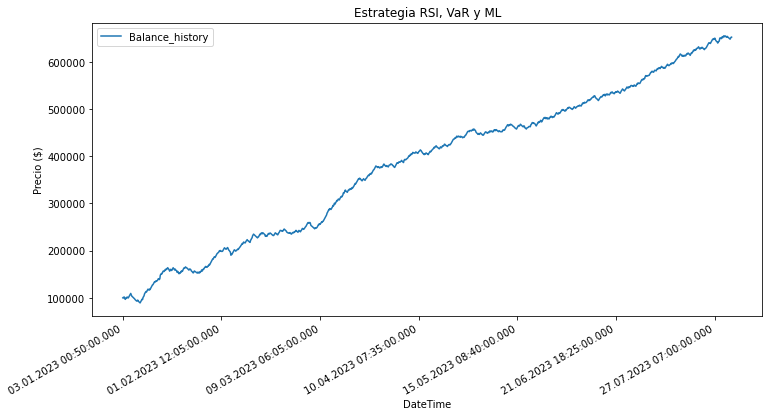

In [33]:
# Crear una figura más grande
plt.figure(figsize=(12, 6))  

# Trazar el gráfico
balance_history['Balance_history'].plot(title="Estrategia RSI, VaR y ML")

# Agregar etiqueta al eje y
plt.ylabel('Precio ($)')

# Rotar automáticamente las etiquetas de fecha
plt.gcf().autofmt_xdate()

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()